# Multi-variate Rregression Metamodel with DOE based on random sampling
* Input variable space should be constructed using random sampling, not classical factorial DOE
* Linear fit is often inadequate but higher-order polynomial fits often leads to overfitting i.e. learns spurious, flawed relationships between input and output
* R-square fit can often be misleding measure in case of high-dimensional regression
* Metamodel can be constructed by selectively discovering features (or their combination) which matter and shrinking other high-order terms towards zero

#### LASSO: Least Absolute Shrinkage and Selection Operator
$$ {\displaystyle \min _{\beta _{0},\beta }\left\{{\frac {1}{N}}\sum _{i=1}^{N}(y_{i}-\beta _{0}-x_{i}^{T}\beta )^{2}\right\}{\text{ subject to }}\sum _{j=1}^{p}|\beta _{j}|\leq t.} $$

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Generate random (equivalent to Latin Hypercube sampling done in Optislang) feature vectors

In [2]:
X=np.array(10*np.random.randn(37,5))

In [3]:
df=pd.DataFrame(X,columns=['Feature'+str(l) for l in range(1,6)])

In [4]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5
0,-6.054888,4.954744,0.706008,-7.876673,13.476252
1,-9.112379,-16.387968,-0.416979,-0.672097,14.290933
2,-0.032246,0.234032,-1.583776,3.060950,3.995919
3,10.353783,6.523231,1.638374,10.981143,-11.433503
4,6.884713,2.680072,-13.577599,10.763904,-6.616147


### Plot the random distributions of input features

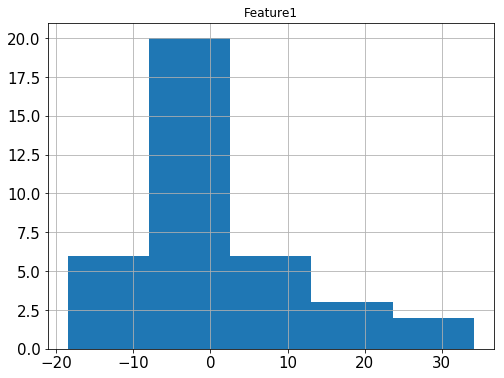

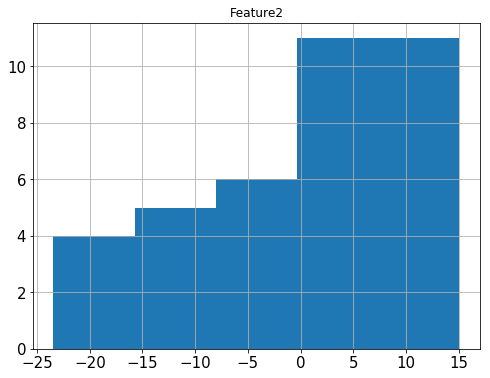

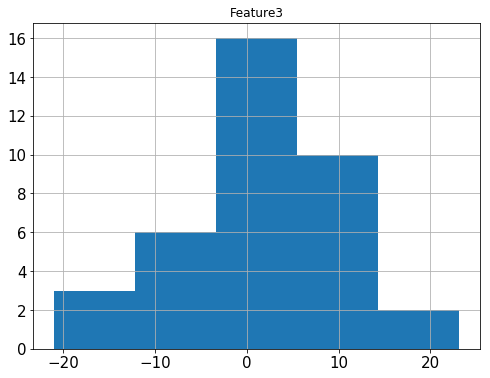

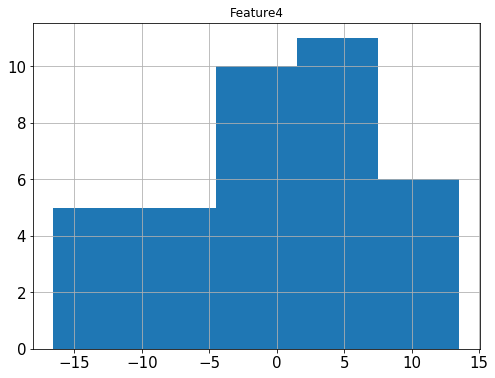

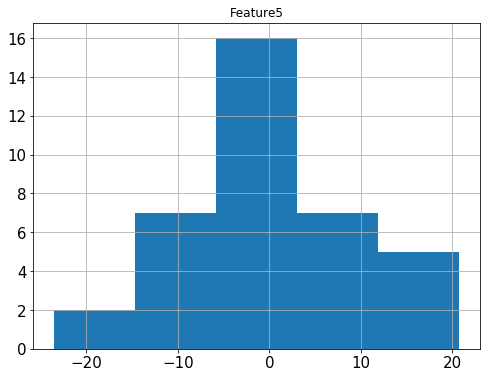

In [5]:
for i in df.columns:
    df.hist(i,bins=5,xlabelsize=15,ylabelsize=15,figsize=(8,6))

### Generate the output variable by analytic function + Gaussian noise (our goal will be to *'learn'* this function)

#### Let's construst the ground  truth  or  originating  function  as  follows: 
 
$$ y=f(x_1,x_2,x_3,x_4,x_5)= 5x_1^2+13x_2+0.1x_1x_3^2+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+\psi(x)\ :\ \psi(x) = {\displaystyle f(x\;|\;\mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}\;e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}}$$

In [6]:
df['y']=5*df['Feature1']**2+13*df['Feature2']+0.1*df['Feature3']**2*df['Feature1'] \
+2*df['Feature4']*df['Feature5']+0.1*df['Feature5']**3+0.8*df['Feature1']*df['Feature4']*df['Feature5'] \
+30*np.random.normal(loc=5,scale=2)

In [7]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,y
0,-6.054888,4.954744,0.706008,-7.876673,13.476252,923.275952
1,-9.112379,-16.387968,-0.416979,-0.672097,14.290933,673.889927
2,-0.032246,0.234032,-1.583776,3.060950,3.995919,162.807983
3,10.353783,6.523231,1.638374,10.981143,-11.433503,-687.702238
4,6.884713,2.680072,-13.577599,10.763904,-6.616147,-35.632538


### Plot single-variable scatterplots

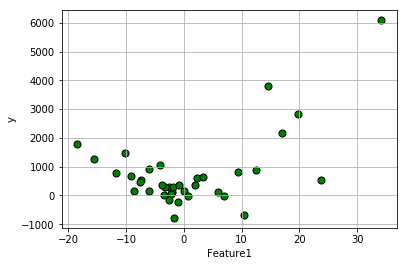

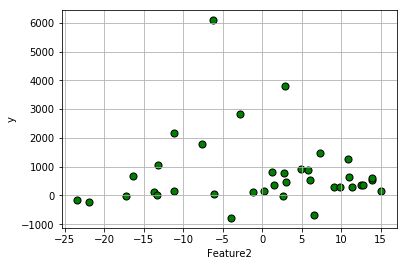

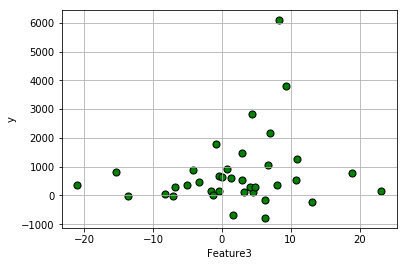

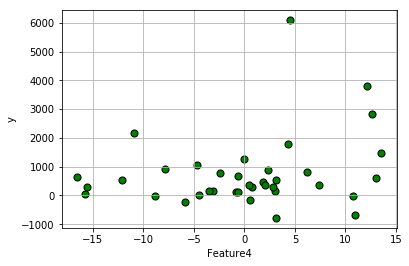

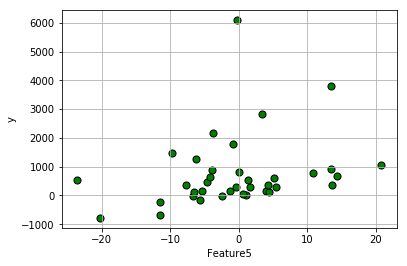

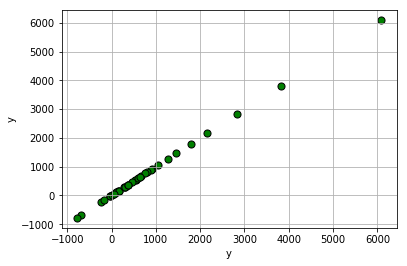

In [8]:
for i in df.columns:
    df.plot.scatter(i,'y', edgecolors=(0,0,0),s=50,c='g',grid=True)

### Standard linear regression

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
linear_model = LinearRegression(normalize=True)

In [11]:
X_linear=df.drop('y',axis=1)
y_linear=df['y']

In [12]:
linear_model.fit(X_linear,y_linear)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [13]:
y_pred_linear = linear_model.predict(X_linear)

### R-square of simple linear fit is very bad, coefficients have no meaning i.e. we did not 'learn' the function

In [14]:
RMSE_linear = np.sqrt(np.sum(np.square(y_pred_linear-y_linear)))

In [15]:
print("Root-mean-square error of linear model:",RMSE_linear)

Root-mean-square error of linear model: 5567.254401779148


In [16]:
coeff_linear = pd.DataFrame(linear_model.coef_,index=df.drop('y',axis=1).columns, columns=['Linear model coefficients'])
coeff_linear

,Linear model coefficients
Feature1,63.206381
Feature2,-0.576087
Feature3,35.918304
Feature4,22.872408
Feature5,54.263715


In [17]:
print ("R2 value of linear model:",linear_model.score(X_linear,y_linear))

R2 value of linear model: 0.46456694945390403


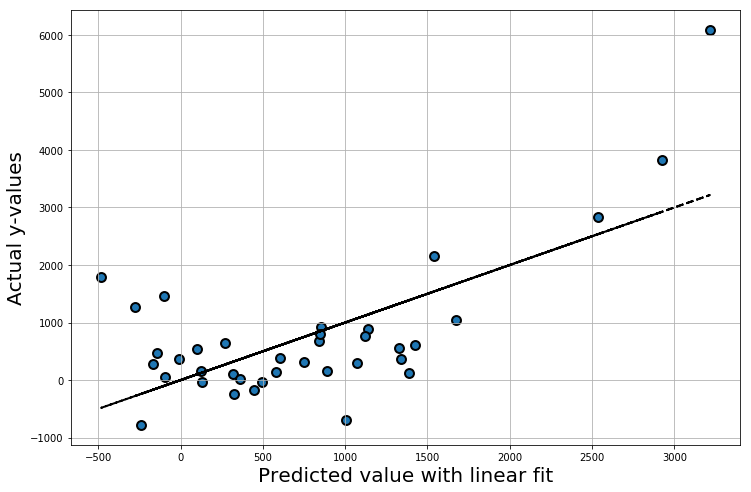

In [18]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with linear fit",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred_linear,y_linear,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred_linear,y_pred_linear, 'k--', lw=2)

### Create polynomial features

In [19]:
from sklearn.preprocessing import PolynomialFeatures

In [20]:
poly = PolynomialFeatures(3,include_bias=False)

In [21]:
X_poly = poly.fit_transform(X)
X_poly_feature_name = poly.get_feature_names(['Feature'+str(l) for l in range(1,6)])
print(X_poly_feature_name)
print(len(X_poly_feature_name))

['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature1^2', 'Feature1 Feature2', 'Feature1 Feature3', 'Feature1 Feature4', 'Feature1 Feature5', 'Feature2^2', 'Feature2 Feature3', 'Feature2 Feature4', 'Feature2 Feature5', 'Feature3^2', 'Feature3 Feature4', 'Feature3 Feature5', 'Feature4^2', 'Feature4 Feature5', 'Feature5^2', 'Feature1^3', 'Feature1^2 Feature2', 'Feature1^2 Feature3', 'Feature1^2 Feature4', 'Feature1^2 Feature5', 'Feature1 Feature2^2', 'Feature1 Feature2 Feature3', 'Feature1 Feature2 Feature4', 'Feature1 Feature2 Feature5', 'Feature1 Feature3^2', 'Feature1 Feature3 Feature4', 'Feature1 Feature3 Feature5', 'Feature1 Feature4^2', 'Feature1 Feature4 Feature5', 'Feature1 Feature5^2', 'Feature2^3', 'Feature2^2 Feature3', 'Feature2^2 Feature4', 'Feature2^2 Feature5', 'Feature2 Feature3^2', 'Feature2 Feature3 Feature4', 'Feature2 Feature3 Feature5', 'Feature2 Feature4^2', 'Feature2 Feature4 Feature5', 'Feature2 Feature5^2', 'Feature3^3', 'Feature3^2 Feature4', 'F

In [22]:
df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3^3,Feature3^2 Feature4,Feature3^2 Feature5,Feature3 Feature4^2,Feature3 Feature4 Feature5,Feature3 Feature5^2,Feature4^3,Feature4^2 Feature5,Feature4 Feature5^2,Feature5^3
0,-6.054888,4.954744,0.706008,-7.876673,13.476252,36.661666,-30.000418,-4.274802,47.692371,-81.597193,...,0.351908,-3.926112,6.717210,43.802162,-74.941408,128.217750,-488.684375,836.093327,-1430.477599,2447.413578
1,-9.112379,-16.387968,-0.416979,-0.672097,14.290933,83.035456,149.333381,3.799671,6.124401,-130.224399,...,-0.072501,-0.116858,2.484786,-0.188355,4.005037,-85.159939,-0.303596,6.455415,-137.262834,2918.648011
2,-0.032246,0.234032,-1.583776,3.060950,3.995919,0.001040,-0.007547,0.051070,-0.098702,-0.128851,...,-3.972660,7.677926,10.023151,-14.839061,-19.371657,-25.288736,28.679324,37.439433,48.875320,63.804303
3,10.353783,6.523231,1.638374,10.981143,-11.433503,107.200823,67.540123,16.963365,113.696371,-118.380007,...,4.397834,29.476333,-30.690588,197.564105,-205.702608,214.176371,1324.166613,-1378.714650,1435.509752,-1494.644485
4,6.884713,2.680072,-13.577599,10.763904,-6.616147,47.399274,18.451525,-93.477872,74.106392,-45.550272,...,-2503.046492,1984.338554,-1219.694523,-1573.122797,966.936441,-594.337634,1247.123546,-766.557579,471.172663,-289.611224


In [23]:
df_poly['y']=df['y']
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3^2 Feature4,Feature3^2 Feature5,Feature3 Feature4^2,Feature3 Feature4 Feature5,Feature3 Feature5^2,Feature4^3,Feature4^2 Feature5,Feature4 Feature5^2,Feature5^3,y
0,-6.054888,4.954744,0.706008,-7.876673,13.476252,36.661666,-30.000418,-4.274802,47.692371,-81.597193,...,-3.926112,6.717210,43.802162,-74.941408,128.217750,-488.684375,836.093327,-1430.477599,2447.413578,923.275952
1,-9.112379,-16.387968,-0.416979,-0.672097,14.290933,83.035456,149.333381,3.799671,6.124401,-130.224399,...,-0.116858,2.484786,-0.188355,4.005037,-85.159939,-0.303596,6.455415,-137.262834,2918.648011,673.889927
2,-0.032246,0.234032,-1.583776,3.060950,3.995919,0.001040,-0.007547,0.051070,-0.098702,-0.128851,...,7.677926,10.023151,-14.839061,-19.371657,-25.288736,28.679324,37.439433,48.875320,63.804303,162.807983
3,10.353783,6.523231,1.638374,10.981143,-11.433503,107.200823,67.540123,16.963365,113.696371,-118.380007,...,29.476333,-30.690588,197.564105,-205.702608,214.176371,1324.166613,-1378.714650,1435.509752,-1494.644485,-687.702238
4,6.884713,2.680072,-13.577599,10.763904,-6.616147,47.399274,18.451525,-93.477872,74.106392,-45.550272,...,1984.338554,-1219.694523,-1573.122797,966.936441,-594.337634,1247.123546,-766.557579,471.172663,-289.611224,-35.632538


In [24]:
X_train=df_poly.drop('y',axis=1)
y_train=df_poly['y']

### Polynomial model without regularization and cross-validation

In [25]:
poly = LinearRegression(normalize=True)

In [26]:
model_poly=poly.fit(X_train,y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)

Root-mean-square error of simple polynomial model: 7.38993139628491e-12


In [27]:
coeff_poly = pd.DataFrame(model_poly.coef_,index=df_poly.drop('y',axis=1).columns, 
                          columns=['Coefficients polynomial model'])
coeff_poly

,Coefficients polynomial model
Feature1,-0.942070
Feature2,12.799089
Feature3,-10.249640
Feature4,-1.263042
Feature5,-7.354561
Feature1^2,3.121500
Feature1 Feature2,1.111090
Feature1 Feature3,-0.206849
Feature1 Feature4,-1.489845
Feature1 Feature5,0.196511


#### R-square value of the simple polynomial model is perfect but the model is flawed as shown above i.e. it learned wrong coefficients and overfitted the to the data

In [28]:
print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))

R2 value of simple polynomial model: 1.0


### Metamodel (Optislang style :) - polynomial model with cross-validation and LASSO regularization
** This is an advanced machine learning method which prevents over-fitting by penalizing high-valued coefficients i.e. keep them bounded **

In [29]:
from sklearn.linear_model import LassoCV

In [30]:
model1 = LassoCV(cv=10,verbose=0,normalize=True,eps=0.001,n_alphas=100, tol=0.0001,max_iter=5000)

In [31]:
model1.fit(X_train,y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=5000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=0)

In [32]:
y_pred1 = np.array(model1.predict(X_train))

In [33]:
RMSE_1=np.sqrt(np.sum(np.square(y_pred1-y_train)))
print("Root-mean-square error of Metamodel:",RMSE_1)

Root-mean-square error of Metamodel: 16.760788703434315


In [34]:
coeff1 = pd.DataFrame(model1.coef_,index=df_poly.drop('y',axis=1).columns, columns=['Coefficients Metamodel'])
coeff1

,Coefficients Metamodel
Feature1,0.012030
Feature2,12.774227
Feature3,-0.000000
Feature4,0.000000
Feature5,0.047323
Feature1^2,4.992291
Feature1 Feature2,-0.000000
Feature1 Feature3,0.000000
Feature1 Feature4,0.000000
Feature1 Feature5,0.000000


In [35]:
model1.score(X_train,y_train)

0.9999951469815446

In [36]:
model1.alpha_

0.1682402228779332

#### Recall that the ground  truth  or  originating  function  is  as  follows: 
 
$$ y=f(x_1,x_2,x_3,x_4,x_5)= 5x_1^2+13x_2+0.1x_1x_3^2+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+\psi(x) $$

### Printing only the non-zero coefficients of the *metamodel*

In [37]:
coeff1[coeff1['Coefficients Metamodel']!=0]

,Coefficients Metamodel
Feature1,0.012030
Feature2,12.774227
Feature5,0.047323
Feature1^2,4.992291
Feature4 Feature5,1.984165
Feature1^3,0.000065
Feature1^2 Feature4,0.000111
Feature1 Feature3^2,0.098697
Feature1 Feature4 Feature5,0.799753
Feature2^3,0.000197


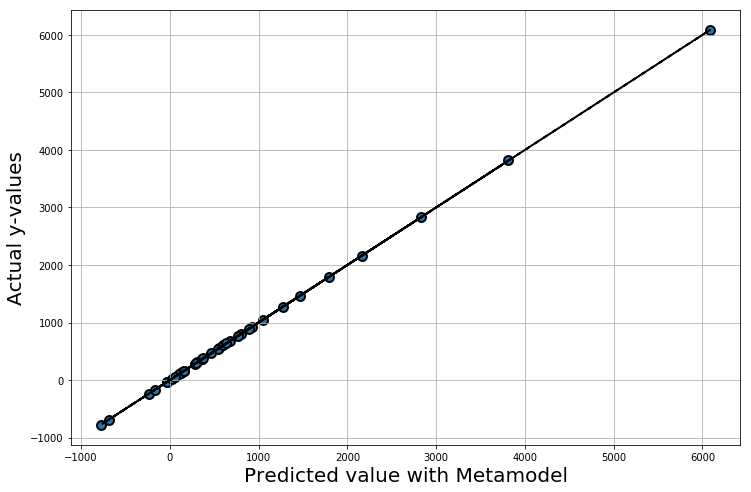

In [38]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with Metamodel",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred1,y_train,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred1,y_pred1, 'k--', lw=2)

(-2.3759298350146434,
 0.9240701649853563,
 -491753.76234681066,
 10326860.672854776)

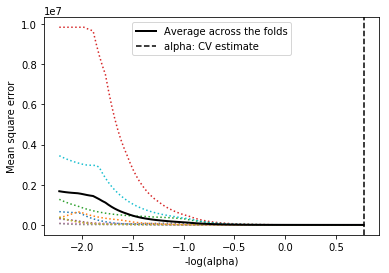

In [39]:
# Display results
m_log_alphas = -np.log10(model1.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model1.mse_path_, ':')
plt.plot(m_log_alphas, model1.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model1.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.axis('tight')